In [57]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

device = "cuda" if torch.cuda.is_available else "cpu"

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)


# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])


xtrain, xtest, ytrain, ytest = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [58]:

class BlobModel(nn.Module):
    def __init__(self, input_features, n_classes, n_neurons = 10) -> None:
        super().__init__()
        self.Linear_block = nn.Sequential(
            nn.Linear(input_features, n_neurons),
            #nn.ReLU(),
            nn.Linear(n_neurons, n_neurons),
            #nn.ReLU(),
            nn.Linear(n_neurons, n_classes),
            #nn.ReLU(),
            #nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.Linear_block(x)

In [59]:
model = BlobModel(NUM_FEATURES, NUM_CLASSES).to(device)
model, next(model.parameters()).is_cuda

(BlobModel(
   (Linear_block): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): Linear(in_features=10, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=4, bias=True)
   )
 ),
 True)

In [60]:
## accuracy function
def accuracy_fn(y_true, y_pred):
    #* torch.eq => comparison between tensor, returns boolean
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = correct/(len(y_pred))*100
    return acc

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)


In [61]:
torch.manual_seed(42)
epochs = 151

xtrain , ytrain = xtrain.to(device), ytrain.to(device)
xtest, ytest = xtest.to(device), ytest.to(device)


In [62]:
for epoch in range(epochs):
    model.train()
    
    logits = model(xtrain)
    y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
    loss = loss_fn(logits, ytrain)
    acc = accuracy_fn(y_pred= y_preds, y_true= ytrain)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    with torch.inference_mode():
        logits = model(xtest)
        y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
        loss_test = loss_fn(logits, ytest)
        acc_test = accuracy_fn(y_pred= y_preds, y_true= ytest)
        
        if epoch % 10 == 0:    
            print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss.item():.4f} | Acc: {acc:.2f}% | Test Loss: {loss_test.item():.4f} | Test Acc: {acc_test:.2f}%")
            


Epoch: 1/151 | Loss: 2.6079 | Acc: 9.12% | Test Loss: 2.2654 | Test Acc: 12.50%
Epoch: 11/151 | Loss: 0.8557 | Acc: 87.00% | Test Loss: 0.8074 | Test Acc: 93.00%
Epoch: 21/151 | Loss: 0.5616 | Acc: 95.75% | Test Loss: 0.5374 | Test Acc: 98.00%
Epoch: 31/151 | Loss: 0.4318 | Acc: 97.25% | Test Loss: 0.4171 | Test Acc: 98.00%
Epoch: 41/151 | Loss: 0.3524 | Acc: 98.38% | Test Loss: 0.3430 | Test Acc: 98.50%
Epoch: 51/151 | Loss: 0.2978 | Acc: 98.75% | Test Loss: 0.2912 | Test Acc: 99.50%
Epoch: 61/151 | Loss: 0.2575 | Acc: 98.75% | Test Loss: 0.2525 | Test Acc: 99.50%
Epoch: 71/151 | Loss: 0.2266 | Acc: 99.00% | Test Loss: 0.2224 | Test Acc: 99.00%
Epoch: 81/151 | Loss: 0.2022 | Acc: 99.00% | Test Loss: 0.1984 | Test Acc: 99.00%
Epoch: 91/151 | Loss: 0.1824 | Acc: 99.00% | Test Loss: 0.1787 | Test Acc: 99.00%
Epoch: 101/151 | Loss: 0.1661 | Acc: 99.00% | Test Loss: 0.1624 | Test Acc: 99.00%
Epoch: 111/151 | Loss: 0.1524 | Acc: 99.00% | Test Loss: 0.1487 | Test Acc: 99.00%
Epoch: 121/151 |

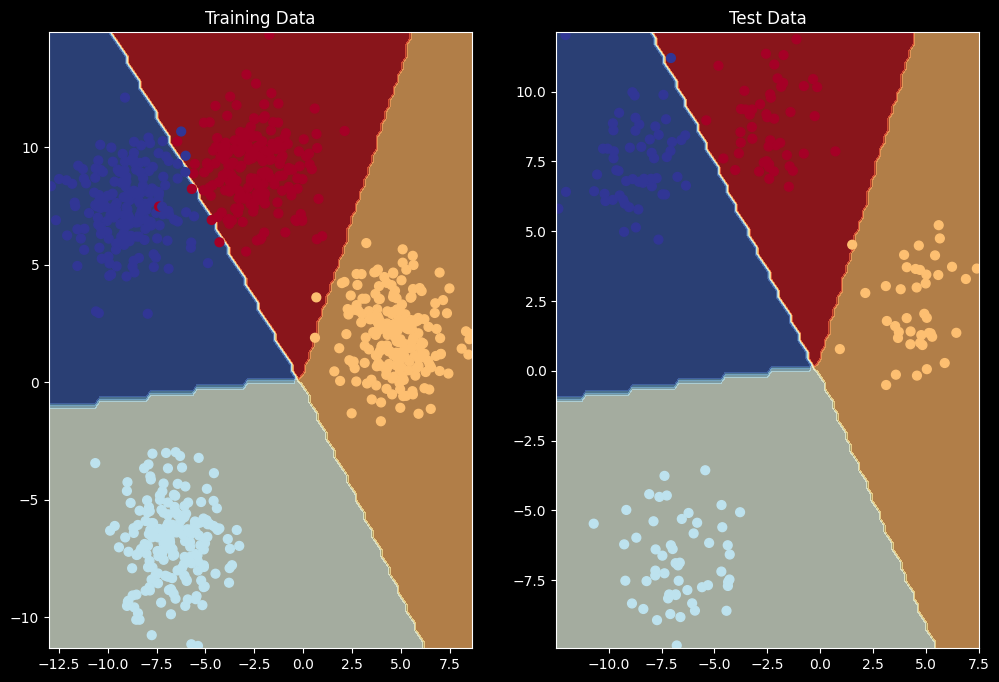

In [63]:
from functions import *

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model, xtrain, ytrain)

plt.subplot(1, 2, 2)
plt.title("Test Data")
plot_decision_boundary(model, xtest, ytest)